# Grover FoM Conditional Run Demo

In [19]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeTorino

from qonscious import run_conditionally

# Importar las clases de la biblioteca Qonscious
from qonscious.actions import QonsciousCallable
from qonscious.adapters import AerSamplerAdapter, IBMSamplerAdapter
from qonscious.checks import MeritComplianceCheck

# Importar la clase FoM Grade para Grover
from qonscious.foms import GroverFigureOfMerit


In [20]:

def phi_plus():
    qc = QuantumCircuit(2, 2)  # 2 qubits, 1 registro clásico de 2 bits (único)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    return qc


In [21]:
from qonscious.adapters import BackendAdapter


def on_pass(backend_adapter : BackendAdapter, figureOfMeritResults):
    firstFoMResult = figureOfMeritResults[0]
    print("Grover FoM passed the compliance check!")
    print(f"Score: {firstFoMResult['properties']['score']:.3f}")
    print("Running our Phi+ circuit")
    run_result = backend_adapter.run(phi_plus(), shots=2048)
    print("Phi+ circuit finished running")
    return run_result

# Este seria el No Op en caso de fallo
fallback = QonsciousCallable(
    lambda adapter, fom_results, **kwargs: None,
)


In [30]:

N_TARGETS = 3 # Número de estados objetivo en el algoritmo de Grover, solo para cuando solo se usa el FoM sin especificar targets
              # ya que son pisados por los del run_conditionally, caso num_qubits como kwargs.
LAMBDA = 0    # Ponderación estricta para uniformidad.
MU = 0  # Ponderación estricta para penalizar el ruido (fail-safe más sensible).
THRESHOLD = 1# Umbral mínimo de score para considerar el hardware 'fiable'.

# Config en el constructor
fom = GroverFigureOfMerit(
    num_targets= N_TARGETS,#notar que el espacio generado si no se definen default_num_qubits
    lambd= LAMBDA, mu=MU,
    default_num_qubits=3,               # 2^4
    default_targets_int=[0],         # 0000 y 0001
    default_shots=1000,
)

In [31]:
def grade_score_over(threshold: float):
    """Función de utilidad para verificar el score GRADE en 'properties'."""
    # Retorna una función lambda que toma el resultado del FoM (r)
    return lambda r: r["properties"]["score"] > threshold

check_grover_is_ok = MeritComplianceCheck(
    figure_of_merit=fom,
    decision_function=lambda r: r["properties"]["score"] > THRESHOLD,
)


In [32]:

#El aer tira resultados perfectos, asi que el score deberia ser cercano a 1.0, solo incertidumbre
#  estadistica
backend_adapter = AerSamplerAdapter()

# Alternativamente, usar un backend IBMQ simulado, que dará resultados más realistas, incertidfumbre
#  de hardware y estadística.
#backend_adapter = IBMSamplerAdapter(FakeManilaV2()) # edit as needed
backend_adapter = IBMSamplerAdapter(FakeTorino()) # edit as needed

"""TODO: Agregar mas backends, como un backend real de IBMQ (requiere configuración de cuenta y token)."""

qonscious_result = run_conditionally(
    backend_adapter=backend_adapter,
    checks=[check_grover_is_ok],
    on_pass=QonsciousCallable(on_pass),
    on_fail=fallback,
)

# Grafico del algoritmo de Grover en Uso
El grafico indica donde es que se van las probabilidades asociados a los targets, no se si deberia se viswible al usuario esta bueno pero la impresion es compleja. 

Propiedades: {'num_qubits': 3, 'search_space_size': 8, 'targets_count': 1, 'grover_iterations': 2, 'target_states': ['000'], 'score': 0.802, 'P_T': 0.802, 'sigma_T': 0.0, 'P_N': 0.19799999999999995, 'lambda_factor': 0, 'mu_factor': 0, 'shots': 1000}
n = 3 counts keys: ['000', '001', '010', '011', '100', '101', '110', '111']


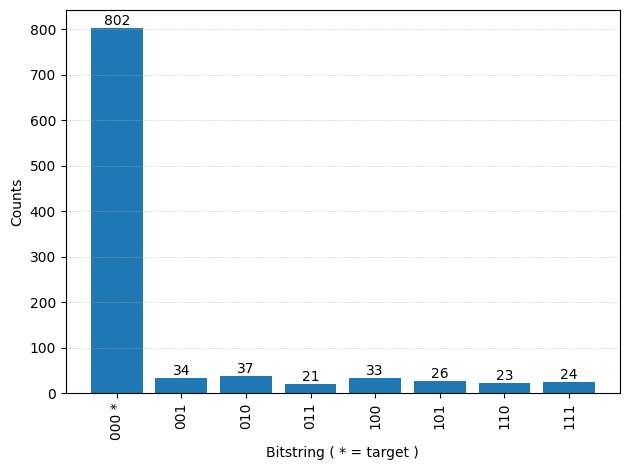

In [33]:
import matplotlib.pyplot as plt

foms = qonscious_result["figures_of_merit_results"]
firstfom = foms[0]
# La impresion quedo rarisima, asi que debe hacerse mejor, cambiar FOM para que tenga un metodo de impresion?
props = firstfom["properties"]
n = props["num_qubits"]
print("Propiedades:", props)
targets = set(props.get("target_states", []) or [])  # ← acá están los targets
# counts = del experimento del FoM (NO del on_pass)
exp = firstfom.get("experiment_result") or {}             # puede ser None u objeto
counts = exp["counts"] if isinstance(exp, dict) else getattr(exp, "counts", {})
print("n =", n, "counts keys:", sorted(counts.keys())[:10])
labels = [format(i, f'0{n}b') for i in range(2**n)]
values = [counts.get(b, 0) for b in labels]
tick_labels = [lbl + (" *" if lbl in targets else "") for lbl in labels]

fig, ax = plt.subplots()
bars = ax.bar(range(len(labels)), values)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_ylabel("Counts"); ax.set_xlabel("Bitstring ( * = target )")
ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
for i, bar in enumerate(bars):
    v = values[i]
    if v: ax.text(bar.get_x()+bar.get_width()/2, v, str(v), ha='center', va='bottom')
plt.tight_layout(); plt.show()



--- Iniciando Experimento 1 (Figura 3) ---
Backend: FakeTorino, N=8, M=[1, 2, 3, 4], mu=1, lambda=1

  Ejecutando N=8, M=1...
  Score obtenido: 0.584
  Ejecutando N=8, M=2...
  Score obtenido: 0.804
  Ejecutando N=8, M=3...
  Score obtenido: 0.548
  Ejecutando N=8, M=4...
  Score obtenido: 0.014

Experimento 1 completado en 81.79s

--- Iniciando Experimento 2 (Figura 2) ---
Backends: Múltiples, M=1, N=[8, 16, 32], mu=0, lambda=0

  Probando Backend: QASMSimulator...
    Ejecutando M=1, N=8 (n=3)...
    Score obtenido: 0.944
    Ejecutando M=1, N=16 (n=4)...
    Score obtenido: 0.956
    Ejecutando M=1, N=32 (n=5)...
    Score obtenido: 1.000
  Probando Backend: FakeQuebec...
    Ejecutando M=1, N=8 (n=3)...
    Score obtenido: 0.755
    Ejecutando M=1, N=16 (n=4)...
    Score obtenido: 0.425
    Ejecutando M=1, N=32 (n=5)...
    Score obtenido: 0.038
  Probando Backend: FakeKawasaki...
    Ejecutando M=1, N=8 (n=3)...
    Score obtenido: 0.786
    Ejecutando M=1, N=16 (n=4)...
    Scor

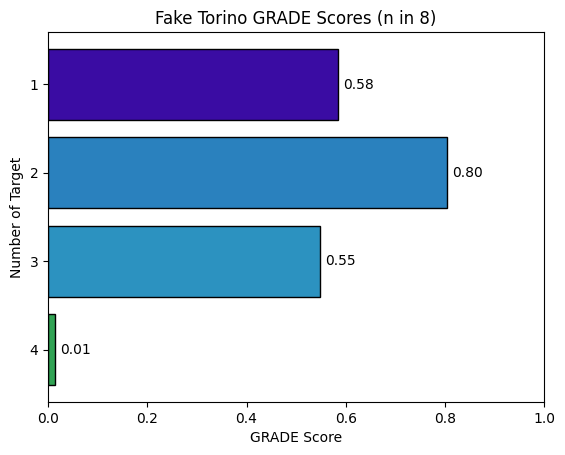

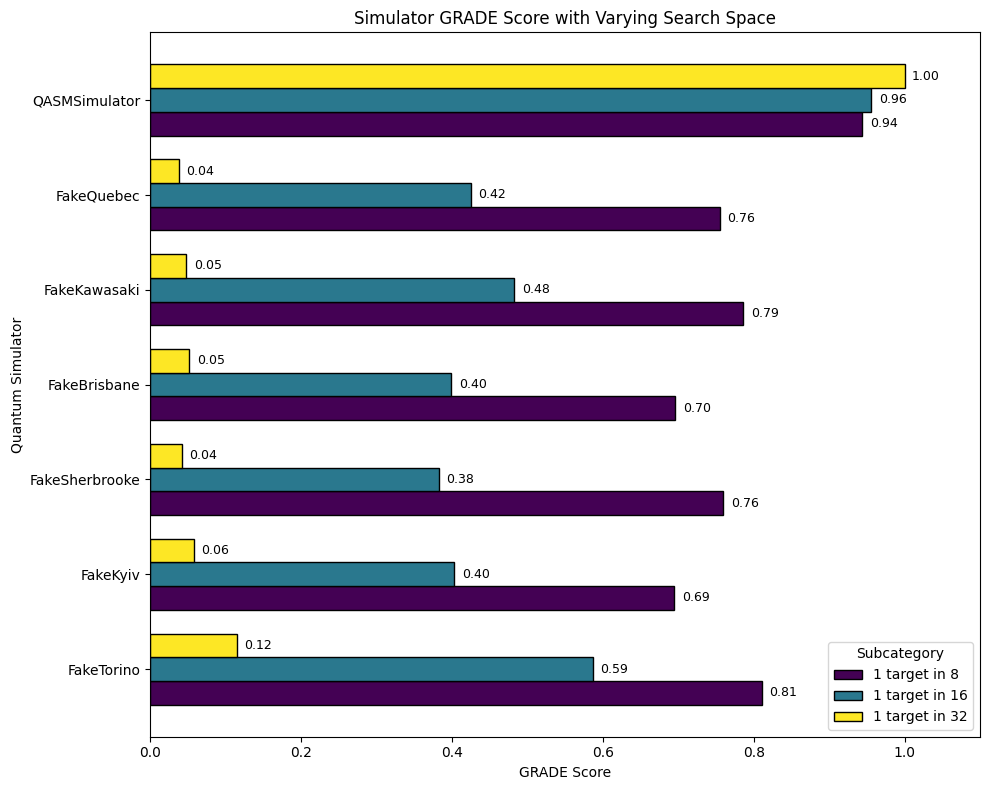

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import time

# --- IMPORTS DE QISKIT Y QONSCIOUS ---
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import (
    FakeQuebec,
    FakeKawasaki,
    FakeBrisbane,
    FakeSherbrooke,
    FakeKyiv,
    FakeTorino,
)
from qonscious.adapters import IBMSamplerAdapter, AerSamplerAdapter

# Importa tu Figura de Mérito (asumiendo que está en grade_fom.py)
# Asegúrate de que este archivo tenga las correcciones de _optimal_grover_rounds
from qonscious.foms import GroverFigureOfMerit

# --- Configuración General ---
shots = 1000  # El paper usó 1000 shots

# ===================================================================
# GRÁFICO 1: Replicando Figura 3 (N=8, M variable, mu=1, lambda=1)
# (Esta sección no se ha modificado)
# ===================================================================
print("--- Iniciando Experimento 1 (Figura 3) ---")
print("Backend: FakeTorino, N=8, M=[1, 2, 3, 4], mu=1, lambda=1\n")

fom_chart1 = GroverFigureOfMerit(
    num_targets=1,
    lambd=1.0, 
    mu=1.0, 
    default_shots=shots
)
adapter_chart1 = IBMSamplerAdapter(FakeTorino())
n_qubits_chart1 = 3  # N=8
target_counts = [1, 2, 3, 4]
scores_chart1 = {}

start_time = time.time()
for M in target_counts:
    targets_int = list(range(M))
    print(f"  Ejecutando N=8, M={M}...")
    result = fom_chart1.evaluate(
        adapter_chart1,
        num_qubits=n_qubits_chart1,
        num_targets=M,
        targets_int=targets_int
    )
    score = result['properties']['score']
    scores_chart1[M] = score
    print(f"  Score obtenido: {score:.3f}")

print(f"\nExperimento 1 completado en {time.time() - start_time:.2f}s")


# ===================================================================
# GRÁFICO 2: Replicando Figura 2 (M=1, N variable, mu=0, lambda=0)
# (### ESTA SECCIÓN HA SIDO COMPLETAMENTE MODIFICADA ###)
# ===================================================================
print("\n--- Iniciando Experimento 2 (Figura 2) ---")
print("Backends: Múltiples, M=1, N=[8, 16, 32], mu=0, lambda=0\n")

# Instanciamos el FoM con los hiperparámetros del paper (mu=0, lambda=0)
fom_chart2 = GroverFigureOfMerit(
    num_targets=1,
    lambd=0.0, 
    mu=0.0, 
    default_shots=shots
)

# n=3 (N=8), n=4 (N=16), n=5 (N=32)
qubit_counts = [3, 4, 5] 

# ### CAMBIO ###
# Creamos la lista de backends en el orden del paper
# (Añadí QASMSimulator porque es la línea base de 1.0 en el gráfico)
all_backends = [
    ("QASMSimulator", AerSamplerAdapter()),
    ("FakeQuebec", IBMSamplerAdapter(FakeQuebec())),
    ("FakeKawasaki", IBMSamplerAdapter(FakeKawasaki())),
    ("FakeBrisbane", IBMSamplerAdapter(FakeBrisbane())),
    ("FakeSherbrooke", IBMSamplerAdapter(FakeSherbrooke())),
    ("FakeKyiv", IBMSamplerAdapter(FakeKyiv())),
    ("FakeTorino", IBMSamplerAdapter(FakeTorino())),
]

# Usaremos un diccionario anidado para guardar los scores
scores_chart2 = {} 

start_time = time.time()

# ### CAMBIO ###
# Bucle externo: iteramos sobre cada backend
for backend_name, backend_adapter in all_backends:
    print(f"  Probando Backend: {backend_name}...")
    scores_chart2[backend_name] = {}
    
    # Bucle interno: iteramos sobre cada tamaño de N
    for n_qubits in qubit_counts:
        N = 2**n_qubits
        data_key = f"N={N}" # Clave para el diccionario
        print(f"    Ejecutando M=1, N={N} (n={n_qubits})...")

        result = fom_chart2.evaluate(
            backend_adapter,
            num_qubits=n_qubits,
            num_targets=1,  
            targets_int=[0]
        )
        
        score = result['properties']['score']
        scores_chart2[backend_name][data_key] = score
        print(f"    Score obtenido: {score:.3f}")

print(f"\nExperimento 2 completado en {time.time() - start_time:.2f}s")
print("NOTA: Este experimento es largo (7 backends * 3 configs = 21 ejecuciones).")


# ===================================================================
# Plotting
# ===================================================================
print("\nGenerando gráficos...")

# --- Gráfico 1 (Sin cambios) ---
fig1, ax1 = plt.subplots()
y_labels1 = list(scores_chart1.keys())
y_pos1 = np.arange(len(y_labels1))
scores1 = list(scores_chart1.values())
colors1 = ['#31a354', '#2c92c0', '#2a81be', '#3a0ca3'] 
colors1.reverse() 
bars1 = ax1.barh(y_pos1, scores1, color=colors1, edgecolor='black')
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(y_labels1)
ax1.invert_yaxis()
ax1.set_xlabel("GRADE Score")
ax1.set_ylabel("Number of Target")
ax1.set_title("Fake Torino GRADE Scores (n in 8)")
ax1.set_xlim(0, 1.0)
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2f}', ha='left', va='center')
plt.show()


# --- Gráfico 2 (### PLOTTING MODIFICADO ###) ---
fig2, ax2 = plt.subplots(figsize=(10, 8)) # Más grande para que quepan los backends

backend_names = list(scores_chart2.keys())
y_pos = np.arange(len(backend_names))

# Extraemos los scores para cada serie (N=8, N=16, N=32)
scores_n8 = [scores_chart2[b]["N=8"] for b in backend_names]
scores_n16 = [scores_chart2[b]["N=16"] for b in backend_names]
scores_n32 = [scores_chart2[b]["N=32"] for b in backend_names]

bar_height = 0.25 # Altura de cada barra individual

# Colores del paper (Púrpura, Verde-azulado, Amarillo)
color_n8 = '#440154'
color_n16 = '#2a788e'
color_n32 = '#fde725'

# Dibujamos las barras agrupadas, desfasando la posición Y
bars_n8 = ax2.barh(y_pos + bar_height, scores_n8, height=bar_height, color=color_n8, edgecolor='black', label='1 target in 8')
bars_n16 = ax2.barh(y_pos, scores_n16, height=bar_height, color=color_n16, edgecolor='black', label='1 target in 16')
bars_n32 = ax2.barh(y_pos - bar_height, scores_n32, height=bar_height, color=color_n32, edgecolor='black', label='1 target in 32')

ax2.set_xlabel("GRADE Score")
ax2.set_ylabel("Quantum Simulator")
ax2.set_title("Simulator GRADE Score with Varying Search Space")
ax2.set_yticks(y_pos)
ax2.set_yticklabels(backend_names)
ax2.invert_yaxis()  # Pone QASMSimulator arriba
ax2.set_xlim(0, 1.1) # Espacio para las etiquetas "1.00"

# Leyenda
ax2.legend(title="Subcategory")

# Función para añadir etiquetas de valor
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{width:.2f}',
                 ha='left', va='center', fontsize=9)

add_labels(bars_n8)
add_labels(bars_n16)
add_labels(bars_n32)

fig2.tight_layout() # Ajusta el layout para que todo quepa
plt.show()

# Impresion del circuito
como en el ipynb de Marcos, Luisma y Josema

In [29]:

import math

import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.visualization import circuit_drawer
from qiskit_aer import AerSimulator


# --- R óptimo (evita overshoot) ---
def optimal_rounds(N: int, M: int) -> int:
    if M <= 0 or M >= N:
        return 0
    theta = math.asin(math.sqrt(M / N))
    R = int(math.floor((math.pi / (4*theta)) - 0.5))
    return max(0, R)

# --- Oráculo multi-target (endianness corregido) ---
def oracle_mt(targets_bin: list[str], n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Oracle")
    tgt = n - 1  # qubit objetivo para MCZ
    for t in targets_bin:
        bits_le = list(reversed(t))                      # Qiskit: qubit 0 es LSB
        zeros = [i for i,b in enumerate(bits_le) if b=='0']
        for i in zeros: qc.x(i)                          # pre-conditioning
        qc.h(tgt); qc.mcx(list(range(n-1)), tgt); qc.h(tgt) if n>1 else qc.x(tgt)
        for i in zeros: qc.x(i)                          # post-conditioning
    return qc

# --- Difusor de Grover ---
def diffuser(n: int) -> QuantumCircuit:
    dq = QuantumCircuit(n, name="Diffusion")
    dq.h(range(n)); dq.x(range(n))
    if n>1:
        dq.h(n-1); dq.mcx(list(range(n-1)), n-1); dq.h(n-1)
    else:
        dq.z(0)
    dq.x(range(n)); dq.h(range(n))
    return dq

# --- Construcción del circuito completo ---
def build_grover(n: int, targets_bin: list[str], R: int|None=None, measure=True):
    N = 2**n
    M = len(targets_bin)
    R = optimal_rounds(N, M) if R is None else R

    qc = QuantumCircuit(n, n if measure else 0, name="Grover")
    qc.h(range(n))
    U = oracle_mt(targets_bin, n)
    D = diffuser(n)
    for _ in range(R):
        qc.compose(U, range(n), inplace=True)
        qc.compose(D, range(n), inplace=True)
        qc.barrier()
    if measure:
        qc.measure(range(n), range(n))
    return qc, U, D, R

# ===== Ejemplo: n=4, targets 0000 y 1001 =====
n = 4
targets = ["1111", "1001"]
qc, U, D, R = build_grover(n, targets, R=None, measure=True)

print(f"n={n}, targets={targets}, R={R}\n")

print("=== ORÁCULO ===")
print(U.draw(output="text", idle_wires=False))

print("\n=== DIFUSOR ===")
print(D.draw(output="text", idle_wires=False))

print("\n=== CIRCUITO COMPLETO ===")
print(qc.draw(output="text", idle_wires=False, cregbundle=True))

# (Opcional) ver el circuito transpiled a las compuertas del simulador
sim = AerSimulator()
tqc = transpile(qc, sim, optimization_level=1)
print("\n=== CIRCUITO TRANSPILE ===")
print(tqc.draw(output="text", idle_wires=False, cregbundle=True))



circuit_drawer(qc, output="mpl", fold=-1)   # fold=-1 para no partir líneas
plt.show()


n=4, targets=['1111', '1001'], R=1

=== ORÁCULO ===
                                   
q_0: ───────■──────────────■───────
            │  ┌───┐       │  ┌───┐
q_1: ───────■──┤ X ├───────■──┤ X ├
            │  ├───┤       │  ├───┤
q_2: ───────■──┤ X ├───────■──┤ X ├
     ┌───┐┌─┴─┐├───┤┌───┐┌─┴─┐├───┤
q_3: ┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘

=== DIFUSOR ===
     ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_3: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

=== CIRCUITO COMPLETO ===
     ┌───┐                         ┌───┐┌───┐               ┌───┐┌───┐      ░ »
q_0: ┤ H ├───────■──────────────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────░─»
     ├───┤       │  ┌───┐       │  ├───┤├───┤┌───┐ 